In [331]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_boston

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable 
import torch.optim as optim #最適化関数
import torch.nn.functional as F #ネットワーク用の様々な関数

## torchtensorに変換する

pytorchではtorchtensorというデータ型が存在し基本的に学習や予測はその型で行う。

In [332]:
x = np.arange(5,dtype=np.float32)
x_torch = torch.tensor(x, requires_grad=True)
x_torch

tensor([0., 1., 2., 3., 4.], requires_grad=True)

## 勾配を計算してみよう

x = 1の時  

$y = x^2+2x$ という数式を考える。微分すると　$\frac{dy}{dx}= 2x+ 2$

In [333]:
x = torch.tensor(1.0, requires_grad=True)
y = x**2+2*x

逆伝搬しないと勾配計算されないようになっているので、勾配計算（微分計算）する際は基本的にbackward()→grad　する

In [334]:
y.backward()
x.grad

tensor(4.)

## y = wx+b を計算してみる

- 入力データxを 100個の特徴量、100サンプル　とする（100,100）
- y は各サンプルに対して、1次元の出力（要するに回帰の場合）を考える　（100,1）

In [335]:
x = np.random.rand(100,100) 
w = nn.Linear(100,1)
b = np.random.rand(100,1) 
x2 = Variable(torch.from_numpy(x).float(), requires_grad=True)

In [336]:
f_x1 = w(x2)

In [337]:
b2 = Variable(torch.from_numpy(b).float(), requires_grad=True)

In [338]:
f_x1 + b2

tensor([[ 0.4672],
        [ 0.7174],
        [-0.0436],
        [-0.0985],
        [-0.3067],
        [ 0.2836],
        [ 0.9473],
        [ 0.4071],
        [ 0.5405],
        [ 0.3711],
        [ 0.7521],
        [ 0.8186],
        [ 0.4896],
        [-0.0189],
        [ 0.2833],
        [ 0.2016],
        [ 0.3963],
        [ 0.9844],
        [-0.2466],
        [ 0.1372],
        [ 0.8606],
        [ 0.4006],
        [ 0.3150],
        [ 0.5781],
        [ 0.3589],
        [ 0.2105],
        [-0.0752],
        [ 0.4745],
        [ 0.5520],
        [ 0.2426],
        [ 0.2094],
        [ 0.0847],
        [ 0.5125],
        [ 0.4473],
        [ 0.2524],
        [ 0.1833],
        [ 0.1161],
        [ 0.2782],
        [ 0.4692],
        [ 0.0467],
        [ 0.0755],
        [-0.0610],
        [ 0.3061],
        [ 0.5607],
        [ 1.0693],
        [ 0.3070],
        [ 0.4778],
        [ 0.4194],
        [ 0.8291],
        [ 1.1097],
        [ 0.4280],
        [ 0.1455],
        [ 0.

## ボストンハウス

In [339]:
from torch.utils.data import TensorDataset, DataLoader 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

boston = load_boston()
x_data = np.array(boston.data)
y_data = np.array(boston.target)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3)

scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

x_train = torch.Tensor(x_train)
x_test = torch.Tensor(x_test)
y_train = torch.Tensor(y_train)
y_test = torch.Tensor(y_test)
 
#データとラベルをセットにしたDatasetを作成
ds_train = TensorDataset(x_train, y_train)
ds_test = TensorDataset(x_test, y_test)
 
#データセットのミニバッチサイズを指定した、Dataloaderを作成
# Chainerのiterators.SerialIteratorと似ている
loader_train = DataLoader(ds_train, batch_size=32, shuffle=True)
loader_test = DataLoader(ds_test, batch_size=32, shuffle=True)

In [340]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(13,1)
        
    def forward(self, x):
        x = self.fc1(x)
        return x

- modelをインスタンス化
- 損失関数の定義
- 最適化手法の定義

In [341]:
model = Model()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

## 学習してみる

In [342]:
num_epoch = 300 

In [343]:
loss_list = []
for epoch in range(num_epoch):  
    #データ全てのトータルロス
    running_loss = 0.0 
    for i, data in enumerate(loader_train):
        #入力データ・ラベルに分割
        # get the inputs
        inputs, labels = data
        # Variableに変形
        inputs, labels = Variable(inputs), Variable(labels)
        # optimizerの初期化
        optimizer.zero_grad()

        #一連の流れ
        outputs = model(inputs)

        out = outputs.view(-1, 1)
        labels = labels.view(-1, 1)
        loss = criterion(outputs, labels) 
        loss.backward()
        optimizer.step()

        # ロスの表示
        running_loss += loss.item()
        
        # 20ミニバッチごとにロスの表示
        if i % 10 == 9:    
            print('[%d, %5d] loss: %.3f' %
                 (epoch + 1, i + 1, running_loss / 10))
            loss_list.append(running_loss)
            running_loss = 0.0
            

[1,    10] loss: 605.214
[2,    10] loss: 504.851
[3,    10] loss: 448.767
[4,    10] loss: 392.630
[5,    10] loss: 335.170
[6,    10] loss: 289.591
[7,    10] loss: 256.405
[8,    10] loss: 216.167
[9,    10] loss: 185.805
[10,    10] loss: 178.437
[11,    10] loss: 147.937
[12,    10] loss: 140.774
[13,    10] loss: 125.124
[14,    10] loss: 106.473
[15,    10] loss: 101.861
[16,    10] loss: 93.091
[17,    10] loss: 79.935
[18,    10] loss: 70.719
[19,    10] loss: 68.511
[20,    10] loss: 57.934
[21,    10] loss: 57.096
[22,    10] loss: 52.582
[23,    10] loss: 50.526
[24,    10] loss: 48.418
[25,    10] loss: 45.422
[26,    10] loss: 40.361
[27,    10] loss: 37.016
[28,    10] loss: 37.747
[29,    10] loss: 37.487
[30,    10] loss: 35.370
[31,    10] loss: 32.108
[32,    10] loss: 31.317
[33,    10] loss: 31.574
[34,    10] loss: 31.601
[35,    10] loss: 27.346
[36,    10] loss: 30.089
[37,    10] loss: 30.058
[38,    10] loss: 27.124
[39,    10] loss: 27.842
[40,    10] loss: 2

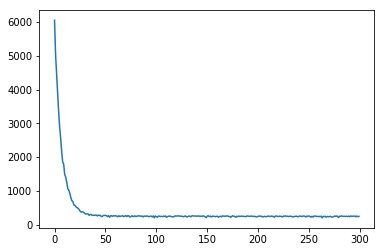

In [344]:
plt.plot(loss_list)
plt.show()

## 推定してみる

In [345]:
pred = model(x_test)
pred2 = pred.reshape(-1).tolist()

## 推定結果に対する考察

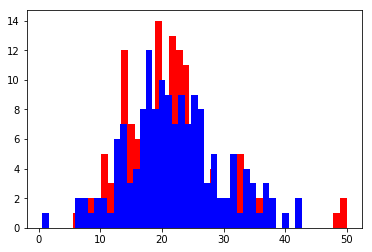

In [346]:
plt.hist(y_test, bins = 40 , color = "r")
plt.hist(pred2, bins = 40, color = "b")
plt.show()

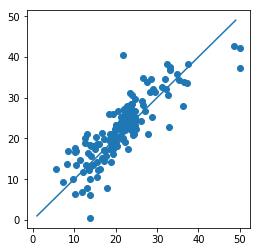

In [347]:
x = np.arange(1,50)
y = x
plt.figure(figsize=(4, 4))
plt.scatter(y_test, pred2)
plt.plot(x,y)
plt.show()

線形モデルなので、データの分布は正規分布になる。正規分布から外れているサンプル（上図の端）では、当てはまりの悪いモデルになっている。